In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
%%javascript
var kernel = Jupyter.notebook.kernel
kernel.execute('kernel_name = ' + '"' + kernel.name + '"')


<IPython.core.display.Javascript object>

In [2]:
kernel_name

'hloc'

In [3]:
from jupyter_client import kernelspec
spec = kernelspec.get_kernel_spec(kernel_name)
print(spec.resource_dir)

/home/shrey.arora_ug25/.local/share/jupyter/kernels/hloc


In [4]:
!which python

/home/shrey.arora_ug25/Hierarchical-Localization/bin/python


In [5]:
%load_ext autoreload
%autoreload 2
import tqdm
import random
from pathlib import Path
import numpy as np

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [6]:
images = Path("datasets/classroom")
outputs = Path("outputs/classroom/")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

feature_conf = extract_features.confs["disk"]
matcher_conf = match_features.confs["disk+lightglue"]

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

88 mapping images


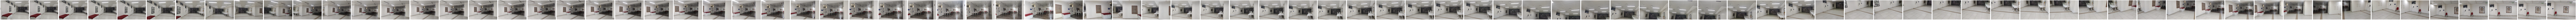

In [7]:
references = [p.relative_to(images).as_posix() for p in (images / "mapping/").iterdir()]
# references = random.sample(references, 35)

print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [8]:
extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)

[2024/12/13 03:26:06 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
100%|███████████████████████████████████████████| 88/88 [00:43<00:00,  2.03it/s]
[2024/12/13 03:26:59 hloc INFO] Finished exporting features.
[2024/12/13 03:26:59 hloc INFO] Found 3828 pairs.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [ ]:
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/12/13 03:27:00 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/home/shrey.arora_ug25/Hierarchical-Localization/lib/python3.11/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
 31%|████████████▎                          | 1205/3828 [08:26<16:35,  2.64it/s]

In [ ]:
r images, gt_translation, gt_rotation in dataloader:
    100     images = images.to("cpu")
    101     gt_translation = gt_translation.to("cpu")

File /apps/compilers/anaconda3-23.07.0/lib/python3.11/smodel = reconstruction.main(
    sfm_dir, images, sfm_pairs, features, matches, image_list=references
)


In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

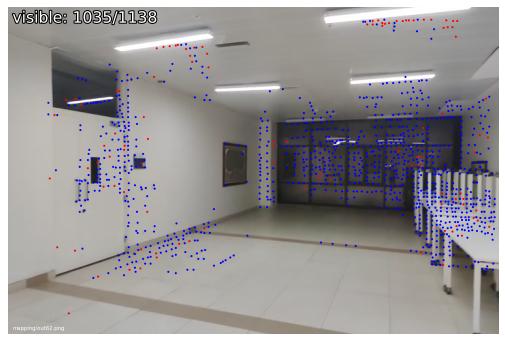

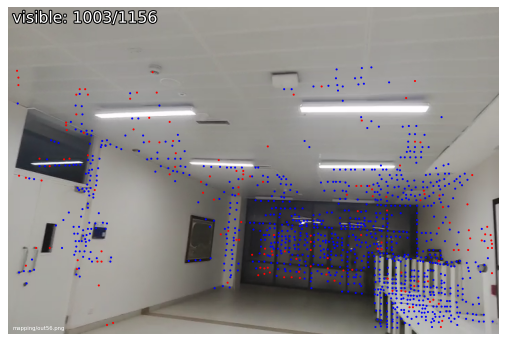

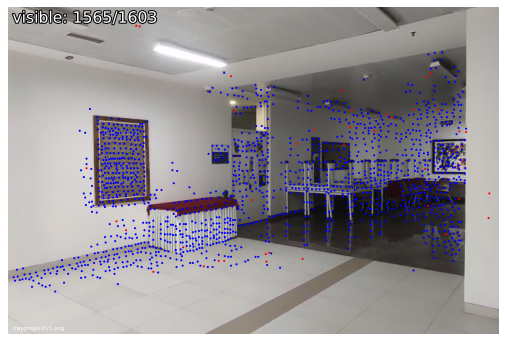

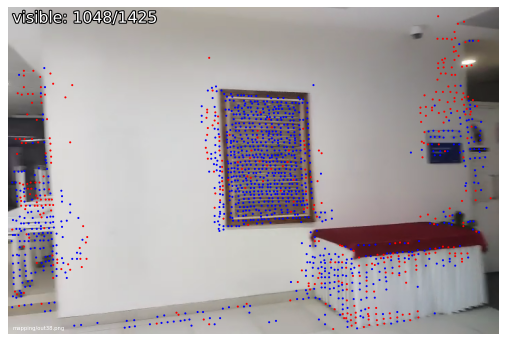

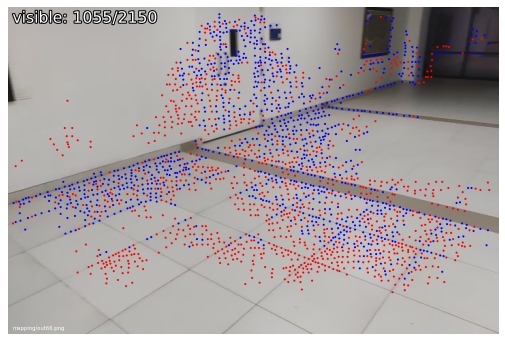

In [26]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

In [28]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from pathlib import Path

# Define the image directory
images_dir = Path("/datasets/classroom")

# List to store results
rot = []
t = []
img_path = []

# Iterate through model images
def extract_camera_poses(model):
    for image_id, image_data in model.images.items():
        # Construct the full path to the image
        image_path = images_dir / image_data.name

        # Access cam_from_world
        cam_from_world = image_data.cam_from_world

        # Get rotation matrix and translation vector
        rotation_matrix = cam_from_world.rotation.matrix()  # Convert to NumPy array
        translation_vector = np.array(cam_from_world.translation)  # Convert to NumPy array

        # Convert rotation matrix to quaternion
        rotation_quaternion = R.from_matrix(rotation_matrix).as_quat()

        # Append results to the lists
        rot.append(rotation_quaternion)
        t.append(translation_vector)
        img_path.append(image_path)

    # Convert paths to strings
    normal_paths = [str(path) for path in img_path]

    # Print results
    print(f"Image Paths: {normal_paths}")
    print("Translations:", t)
    print("Rotations (Quaternions):", rot)

    # Save results to a file
    output_file = "camera_poses.txt"
    with open(output_file, "w") as f:
        f.write("Image Path\tTranslation\tRotation (Quaternion)\n")
        for path, trans, quat in zip(normal_paths, t, rot):
            f.write(f"{path}\t{trans.tolist()}\t{quat.tolist()}\n")

    print(f"Results saved to {output_file}")

# Call the function with your model
# extract_camera_poses(model)


In [29]:
extract_camera_poses(model)

Image Paths: ['/datasets/classroom/mapping/out1.png', '/datasets/classroom/mapping/out10.png', '/datasets/classroom/mapping/out11.png', '/datasets/classroom/mapping/out12.png', '/datasets/classroom/mapping/out13.png', '/datasets/classroom/mapping/out14.png', '/datasets/classroom/mapping/out15.png', '/datasets/classroom/mapping/out16.png', '/datasets/classroom/mapping/out17.png', '/datasets/classroom/mapping/out18.png', '/datasets/classroom/mapping/out19.png', '/datasets/classroom/mapping/out2.png', '/datasets/classroom/mapping/out20.png', '/datasets/classroom/mapping/out21.png', '/datasets/classroom/mapping/out22.png', '/datasets/classroom/mapping/out23.png', '/datasets/classroom/mapping/out24.png', '/datasets/classroom/mapping/out25.png', '/datasets/classroom/mapping/out26.png', '/datasets/classroom/mapping/out27.png', '/datasets/classroom/mapping/out28.png', '/datasets/classroom/mapping/out29.png', '/datasets/classroom/mapping/out3.png', '/datasets/classroom/mapping/out30.png', '/dat